In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from diploma.data.hierarchy import Hierarchy

In [2]:
import scienceplots
plt.style.use('ggplot')
plt.style.use('science')

In [3]:
# dataset_dir     = '/media/ap/Transcend/Projects/diploma/_local/diploma/assets/data/tmp/openimages'
# samples_dir     = '/media/ap/Transcend/Projects/diploma/_local/diploma/assets/data/tmp/openimages/samples'
# splits_json     = '/media/ap/Transcend/Projects/diploma/_local/diploma/assets/data/tmp/openimages/splits.json'
# hierarchy_json  = '/media/ap/Transcend/Projects/diploma/_local/diploma/assets/data/tmp/openimages/hierarchy.json'
# categories_json = '/media/ap/Transcend/Projects/diploma/_local/diploma/assets/data/tmp/openimages/categories.json'
# images_dir      = '/media/ap/Transcend/Projects/diploma/_local/diploma/assets/data/tmp/openimages/images'

# reports_dir     = '/media/ap/Transcend/Projects/diploma/reports/diploma/assets'


dataset_dir     = '/media/ap/Transcend/Projects/diploma/assets/data/tmp/openimages'
samples_dir     = '/media/ap/Transcend/Projects/diploma/assets/data/tmp/openimages/samples'
splits_json     = '/media/ap/Transcend/Projects/diploma/assets/data/tmp/openimages/splits.json'
hierarchy_json  = '/media/ap/Transcend/Projects/diploma/assets/data/tmp/openimages/hierarchy.json'
categories_json = '/media/ap/Transcend/Projects/diploma/assets/data/tmp/openimages/categories.json'
images_dir      = '/media/ap/Transcend/Projects/diploma/assets/data/tmp/openimages/images'

reports_dir     = '/media/ap/Transcend/Projects/diploma/reports/diploma/assets'

## Hierarchy Graph

In [4]:
hierarchy = Hierarchy.from_json(hierarchy_json)

In [5]:
def add_nodes(graph, node_dict):
    for key, value in node_dict.items():
        if value is None:
            graph.node(key)
        else:
            graph.node(key)
            add_nodes(graph, value)
            for k in value.keys():
                graph.edge(key, k)

graph = graphviz.Digraph()
add_nodes(graph, hierarchy.dct)
graph.render(filename='hierarchy',
             directory=reports_dir,
             view=True, format='png')

'/media/ap/Transcend/Projects/diploma/reports/diploma/assets/hierarchy.png'

## Samples Distribution

In [6]:
from pathlib import Path
import json

In [7]:
splits = json.loads(Path(splits_json).read_text())

In [8]:
data = []
for split in splits:
    for sample in splits[split]:
        data.append({
            'Path': Path(samples_dir) / sample,
            'Category': sample.split('/')[0],
            'Split': split
        })

In [9]:
samples_df = pd.DataFrame(data)

In [10]:
samples_df

,Path,Category,Split
0,/media/ap/Transcend/Projects/diploma/assets/da...,Cat,train
1,/media/ap/Transcend/Projects/diploma/assets/da...,Cat,train
2,/media/ap/Transcend/Projects/diploma/assets/da...,Cat,train
3,/media/ap/Transcend/Projects/diploma/assets/da...,Cat,train
4,/media/ap/Transcend/Projects/diploma/assets/da...,Cat,train
...,...,...,...
4395,/media/ap/Transcend/Projects/diploma/assets/da...,Eagle,val
4396,/media/ap/Transcend/Projects/diploma/assets/da...,Eagle,val
4397,/media/ap/Transcend/Projects/diploma/assets/da...,Eagle,val
4398,/media/ap/Transcend/Projects/diploma/assets/da...,Eagle,val


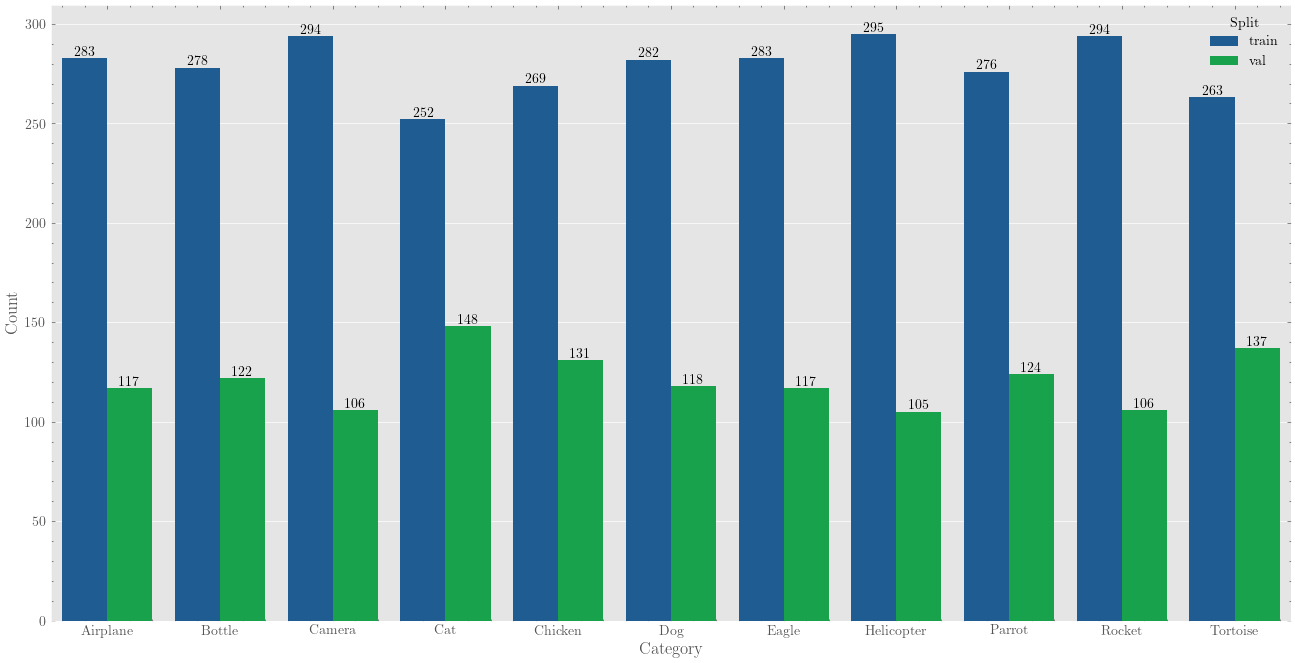

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
categories = sorted(samples_df['Category'].unique().tolist())
sns.countplot(data=samples_df,
              x='Category',
              hue='Split',
              order=categories,
              ax=ax)
for i in ax.containers:
    ax.bar_label(i)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
fig.savefig(Path(reports_dir) / "SamplesPerSplit.png")

In [12]:
samples_df.value_counts('Split')

Split
train    3069
val      1331
Name: count, dtype: int64

In [13]:
samples_df.shape[0]

4400

In [14]:
samples_df['Category'].unique().shape[0]

11

## Samples Examples

In [15]:
from PIL import Image

In [16]:
%matplotlib inline

In [23]:
n = 10 # samples per category
categories = sorted(samples_df['Category'].unique().tolist())

fig, axs = plt.subplots(
    len(categories),
    n,
    figsize=(16, 24),
    sharex=True,
    sharey=True,
)

for ax, category in zip(axs, categories):
    samples = samples_df.query('Category == @category').sample(n)
    images = [np.asarray(Image.open(sample).resize((128, 128)))
              for sample in samples['Path'].tolist()]
    for i in range(n):
        ax[i].imshow(images[i])
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].set_title(category)

plt.tight_layout()
plt.savefig(Path(reports_dir) / "SamplesExamples.png")

## Training Results

In [17]:
hierarchy_logs_path = '/media/ap/Transcend/Projects/diploma/assets/runs/image-classification-hierarchy/2023-04-13_19-02-18-118476/lightning_logs/version_1/metrics.csv'
onehot_logs_path    = '/media/ap/Transcend/Projects/diploma/assets/runs/image-classification-onehot/2023-04-13_19-27-31-597629/lightning_logs/version_1/metrics.csv'
hierarchy_cm_path   = '/media/ap/Transcend/Projects/diploma/assets/runs/image-classification-hierarchy/2023-04-13_19-02-18-118476/lightning_logs/version_0/confusion_matrix/epoch_0051/validation/cm.csv'
onehot_cm_path      = '/media/ap/Transcend/Projects/diploma/assets/runs/image-classification-onehot/2023-04-13_19-27-31-597629/lightning_logs/version_0/confusion_matrix/epoch_0009/validation/cm.csv'

hierarchy_df = pd.read_csv(hierarchy_logs_path)
onehot_df = pd.read_csv(onehot_logs_path)

In [18]:
def read_metrics(df):
    df = df[[
        'step',
        'epoch',
        'accuracy/validation',
        'precision/validation',
        'recall/validation',
        'f1/validation',
    ]]
    return df[~df.isna().any(axis=1)]

In [34]:
hierarchy_metrics = read_metrics(hierarchy_df)
hierarchy_metrics['Approach'] = 'Hierarchy'
onehot_metrics = read_metrics(onehot_df)
onehot_metrics['Approach'] = 'OneHot'

metrics = pd.concat([hierarchy_metrics, onehot_metrics]).reset_index(drop=True)

In [35]:
metrics

,step,epoch,accuracy/validation,precision/validation,recall/validation,f1/validation,Approach
0,46,0.0,0.732633,0.753116,0.732633,0.721061,Hierarchy
1,93,1.0,0.786453,0.788076,0.786453,0.778280,Hierarchy
2,140,2.0,0.804271,0.803095,0.804271,0.800600,Hierarchy
3,187,3.0,0.806758,0.806831,0.806758,0.803075,Hierarchy
4,234,4.0,0.803476,0.805524,0.803476,0.802128,Hierarchy
...,...,...,...,...,...,...,...
219,7754,164.0,0.827166,0.827562,0.827166,0.825138,OneHot
220,7801,165.0,0.828432,0.825346,0.828432,0.825207,OneHot
221,7848,166.0,0.821921,0.820574,0.821921,0.818753,OneHot
222,7895,167.0,0.829541,0.831341,0.829541,0.828839,OneHot


In [36]:
metrics.query('Approach == "OneHot"').sort_values('f1/validation').tail()

,step,epoch,accuracy/validation,precision/validation,recall/validation,f1/validation,Approach
93,1832,38.0,0.833573,0.832189,0.833573,0.832291,OneHot
63,422,8.0,0.833551,0.840102,0.833551,0.833026,OneHot
59,234,4.0,0.837604,0.836187,0.837604,0.835803,OneHot
57,140,2.0,0.837241,0.841274,0.837241,0.836470,OneHot
64,469,9.0,0.842864,0.843639,0.842864,0.841674,OneHot


In [37]:
metrics.query('Approach == "Hierarchy"').sort_values('f1/validation').tail()

,step,epoch,accuracy/validation,precision/validation,recall/validation,f1/validation,Approach
48,2302,48.0,0.838434,0.838304,0.838434,0.837208,Hierarchy
44,2114,44.0,0.840742,0.838002,0.840742,0.838841,Hierarchy
53,2537,53.0,0.838956,0.843463,0.838956,0.838890,Hierarchy
52,2490,52.0,0.843775,0.844460,0.843775,0.842670,Hierarchy
51,2443,51.0,0.843622,0.844194,0.843622,0.842751,Hierarchy


In [38]:
metrics.loc[[51, 64]]

,step,epoch,accuracy/validation,precision/validation,recall/validation,f1/validation,Approach
51,2443,51.0,0.843622,0.844194,0.843622,0.842751,Hierarchy
64,469,9.0,0.842864,0.843639,0.842864,0.841674,OneHot


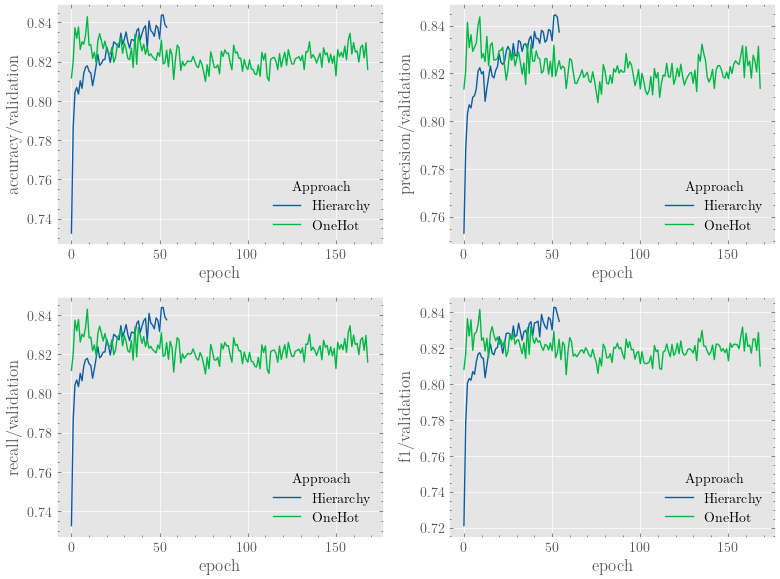

In [28]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(8, 6),
)

sns.lineplot(
    data=metrics,
    x='epoch',
    y='accuracy/validation',
    hue='Approach',
    ax=axs[0, 0]
)

sns.lineplot(
    data=metrics,
    x='epoch',
    y='precision/validation',
    hue='Approach',
    ax=axs[0, 1]
)
sns.lineplot(
    data=metrics,
    x='epoch',
    y='recall/validation',
    hue='Approach',
    ax=axs[1, 0]
)
sns.lineplot(
    data=metrics,
    x='epoch',
    y='f1/validation',
    hue='Approach',
    ax=axs[1, 1]
)

plt.tight_layout()
plt.savefig(Path(reports_dir) / "Metrics.png")

In [22]:
def read_losses(df):
    df = df[[
        'step',
        'epoch',
        *list(filter(lambda s: 'loss' in s, df.columns))
    ]]
    return df

In [23]:
loss_columns = list(filter(lambda s: 'loss' in s, hierarchy_df.columns))
display(loss_columns)

loss_columns = list(filter(lambda s: 'loss' in s, onehot_df.columns))
display(loss_columns)

['loss/train_step',
 'loss_L_bce/train_step',
 'loss_L_sim/train_step',
 'loss_L_cat/train_step',
 'loss_L_seq/train_step',
 'loss_L_lvl/train_step',
 'loss/validation_step',
 'loss_L_bce/validation_step',
 'loss_L_sim/validation_step',
 'loss_L_cat/validation_step',
 'loss_L_seq/validation_step',
 'loss_L_lvl/validation_step',
 'loss/validation_epoch',
 'loss_L_bce/validation_epoch',
 'loss_L_sim/validation_epoch',
 'loss_L_cat/validation_epoch',
 'loss_L_seq/validation_epoch',
 'loss_L_lvl/validation_epoch',
 'loss/train_epoch',
 'loss_L_bce/train_epoch',
 'loss_L_sim/train_epoch',
 'loss_L_cat/train_epoch',
 'loss_L_seq/train_epoch',
 'loss_L_lvl/train_epoch']

['loss/train_step',
 'loss_bce/train_step',
 'loss/validation_step',
 'loss_bce/validation_step',
 'loss/validation_epoch',
 'loss_bce/validation_epoch',
 'loss/train_epoch',
 'loss_bce/train_epoch']

In [24]:
hierarchy_losses = read_losses(hierarchy_df)
hierarchy_losses['Approach'] = 'Hierarchy'
onehot_losses = read_losses(onehot_df)
onehot_losses['Approach'] = 'OneHot'

losses = pd.concat([hierarchy_losses, onehot_losses])

/tmp/ipykernel_47199/601098365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hierarchy_losses['Approach'] = 'Hierarchy'
/tmp/ipykernel_47199/601098365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onehot_losses['Approach'] = 'OneHot'


In [25]:
losses

,step,epoch,loss/train_step,loss_L_bce/train_step,loss_L_sim/train_step,loss_L_cat/train_step,loss_L_seq/train_step,loss_L_lvl/train_step,loss/validation_step,loss_L_bce/validation_step,...,loss_L_bce/train_epoch,loss_L_sim/train_epoch,loss_L_cat/train_epoch,loss_L_seq/train_epoch,loss_L_lvl/train_epoch,Approach,loss_bce/train_step,loss_bce/validation_step,loss_bce/validation_epoch,loss_bce/train_epoch
0,0,0.0,0.032770,0.010671,2.721367e-05,0.010788,0.010671,0.010732,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hierarchy,NaN,NaN,NaN,NaN
1,1,0.0,0.030383,0.010825,3.510161e-07,0.010498,0.010824,0.010821,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hierarchy,NaN,NaN,NaN,NaN
2,2,0.0,0.028193,0.009050,4.087627e-05,0.013041,0.009050,0.009064,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hierarchy,NaN,NaN,NaN,NaN
3,3,0.0,0.026397,0.009024,1.186796e-04,0.015139,0.009024,0.008961,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hierarchy,NaN,NaN,NaN,NaN
4,4,0.0,0.024598,0.008846,7.266287e-05,0.012370,0.008846,0.008914,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hierarchy,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11848,7961,169.0,0.000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OneHot,0.000013,NaN,NaN,NaN
11849,7962,169.0,0.000232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OneHot,0.000232,NaN,NaN,NaN
11850,7963,169.0,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OneHot,0.000004,NaN,NaN,NaN
11851,7964,169.0,0.000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OneHot,0.000024,NaN,NaN,NaN


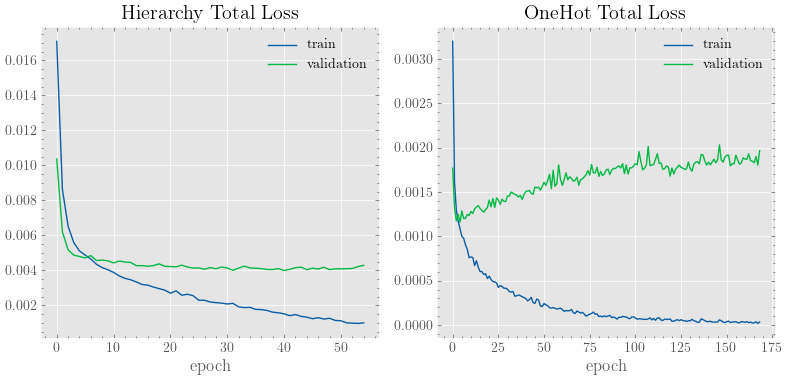

In [33]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(8, 4),
)

sns.lineplot(
    data=losses[~losses['loss/train_epoch'].isna()].query('Approach == "Hierarchy"'),
    x='epoch',
    y='loss/train_epoch',
    ax=axs[0],
    label='train',
)
sns.lineplot(
    data=losses[~losses['loss/validation_epoch'].isna()].query('Approach == "Hierarchy"'),
    x='epoch',
    y='loss/validation_epoch',
    ax=axs[0],
    label='validation',
)

sns.lineplot(
    data=losses[~losses['loss/train_epoch'].isna()].query('Approach == "OneHot"'),
    x='epoch',
    y='loss/train_epoch',
    ax=axs[1],
    label='train',
)
sns.lineplot(
    data=losses[~losses['loss/validation_epoch'].isna()].query('Approach == "OneHot"'),
    x='epoch',
    y='loss/validation_epoch',
    ax=axs[1],
    label='validation',
)

axs[0].set_title('Hierarchy Total Loss')
axs[0].legend()
axs[0].set_ylabel("")
axs[1].set_title('OneHot Total Loss')
axs[1].legend()
axs[1].set_ylabel("")

plt.tight_layout()
plt.savefig(Path(reports_dir) / "TotalLoss.png")

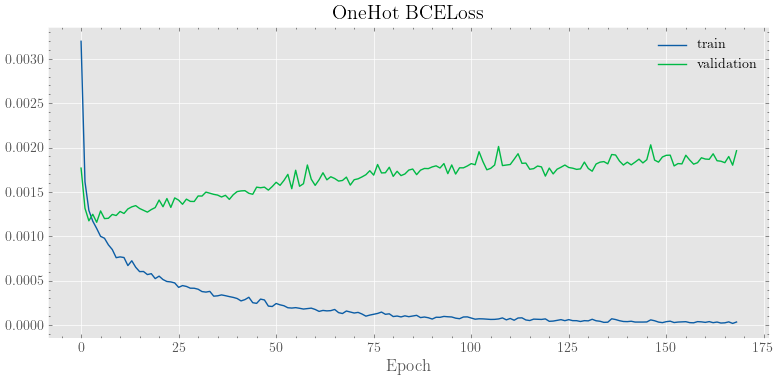

In [34]:
fig, axs = plt.subplots(
    figsize=(8, 4),
)

sns.lineplot(
    data=losses[~losses['loss_bce/train_epoch'].isna()].query('Approach == "OneHot"'),
    x='epoch',
    y='loss_bce/train_epoch',
    ax=axs,
    label='train',
)
sns.lineplot(
    data=losses[~losses['loss_bce/validation_epoch'].isna()].query('Approach == "OneHot"'),
    x='epoch',
    y='loss_bce/validation_epoch',
    ax=axs,
    label='validation',
)

axs.set_xlabel("Epoch")
axs.set_ylabel("")
axs.set_title("OneHot BCELoss")
axs.legend()

plt.tight_layout()
plt.savefig(Path(reports_dir) / "OneHotBCELoss.png")

In [26]:
l = losses[['loss_L_bce/validation_epoch', 'loss_L_seq/validation_epoch', 'loss_L_lvl/validation_epoch']]
l = l[~l.isna().any(axis=1)]

In [27]:
l

,loss_L_bce/validation_epoch,loss_L_seq/validation_epoch,loss_L_lvl/validation_epoch
68,0.003511,0.003438,0.003715
138,0.001914,0.001544,0.002119
208,0.002466,0.002015,0.002752
278,0.001652,0.001426,0.001788
348,0.001824,0.001595,0.001945
418,0.001501,0.001204,0.001604
488,0.001750,0.001481,0.001854
558,0.001554,0.001301,0.001696
628,0.001540,0.001293,0.001604
698,0.001960,0.001752,0.002045


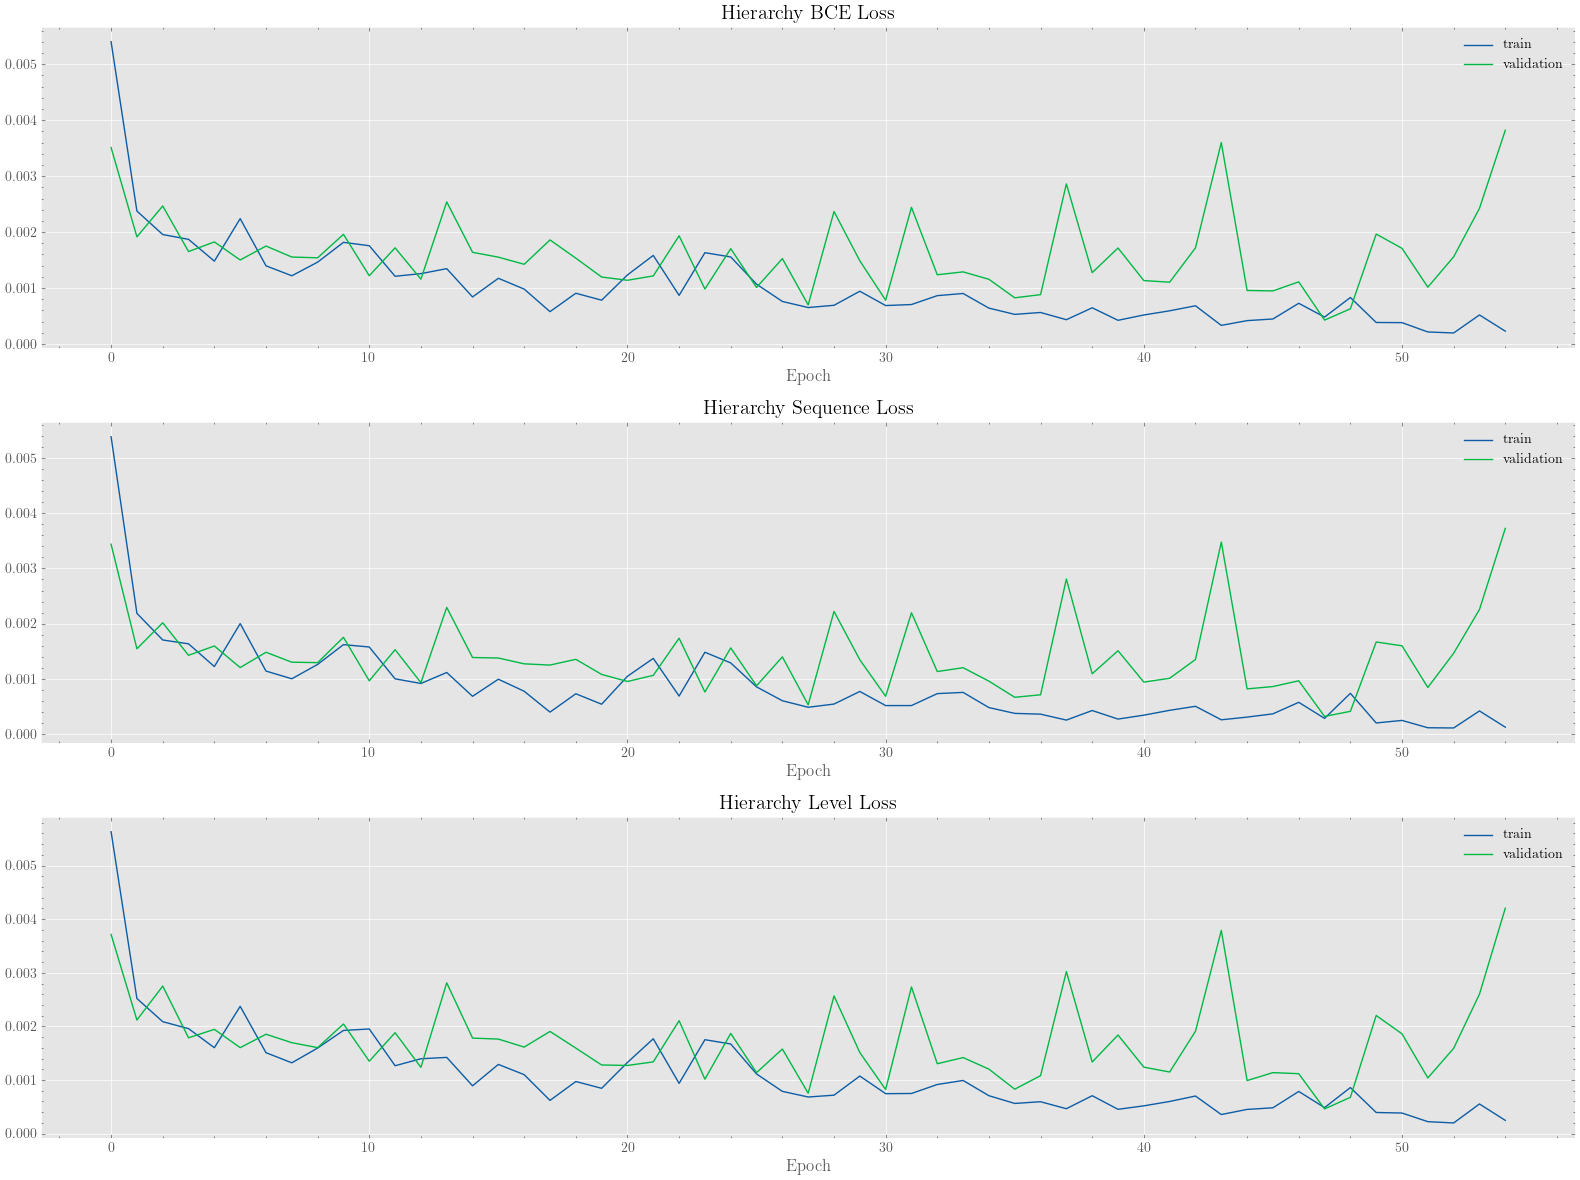

In [37]:
fig, axs = plt.subplots(
    3,
    1,
    figsize=(16, 12),
)
axs = axs.ravel()

for ax, (loss_name, loss_alias) in zip(axs, [
    ["loss_L_bce", "Hierarchy BCE Loss"],
    ["loss_L_seq", "Hierarchy Sequence Loss"],
    ["loss_L_lvl", "Hierarchy Level Loss"],
]):
    sns.lineplot(
        data=losses[~losses[f'{loss_name}/train_epoch'].isna()].query('Approach == "Hierarchy"'),
        x='epoch',
        y=f'{loss_name}/train_epoch',
        ax=ax,
        label='train'
    )
    sns.lineplot(
        data=losses[~losses[f'{loss_name}/validation_epoch'].isna()].query('Approach == "Hierarchy"'),
        x='epoch',
        y=f'{loss_name}/validation_epoch',
        ax=ax,
        label='validation'
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("")
    ax.set_title(loss_alias)
    ax.legend()
    
    
plt.tight_layout()
plt.savefig(Path(reports_dir) / "HierarchyLosses.png")

In [28]:
hierarchy_cm = pd.read_csv(hierarchy_cm_path, header=0, index_col=0)
onehot_cm = pd.read_csv(onehot_cm_path, header=0, index_col=0)

In [29]:
from IPython.display import display

In [30]:
display(hierarchy_cm)
display(onehot_cm)

,Rocket,Airplane,Helicopter,Bottle,Camera,Chicken,Eagle,Parrot,Cat,Dog,Tortoise
Rocket,95,3,1,6,1,0,0,0,0,0,0
Airplane,1,103,6,0,0,2,2,1,1,0,1
Helicopter,0,9,87,1,0,0,5,1,0,0,2
Bottle,2,0,0,109,6,0,0,1,2,1,1
Camera,1,2,0,4,99,0,0,0,0,0,0
Chicken,0,0,0,1,0,97,2,7,12,9,3
Eagle,0,5,1,0,0,0,104,4,0,2,1
Parrot,2,1,0,3,1,5,9,99,3,1,0
Cat,0,1,0,4,2,8,3,2,103,21,4
Dog,0,0,0,1,0,2,5,0,13,94,3


,Rocket,Airplane,Helicopter,Bottle,Camera,Chicken,Eagle,Parrot,Cat,Dog,Tortoise
Rocket,100,2,1,3,0,0,0,0,0,0,0
Airplane,2,95,14,0,0,1,3,1,0,0,1
Helicopter,0,9,90,0,0,0,3,1,0,0,2
Bottle,5,0,0,105,7,1,0,1,3,0,0
Camera,1,1,0,1,101,0,0,1,0,0,1
Chicken,0,1,0,1,0,99,2,5,15,5,3
Eagle,1,5,2,1,0,1,104,1,0,0,2
Parrot,1,2,1,2,1,9,10,96,2,0,0
Cat,0,0,1,2,4,5,1,2,122,10,1
Dog,1,1,0,1,1,4,6,0,19,84,1


In [31]:
from pycm import ConfusionMatrix

In [32]:
hierarchy_cm_obj = ConfusionMatrix(matrix=hierarchy_cm.to_dict())
onehot_cm_obj = ConfusionMatrix(matrix=onehot_cm.to_dict())

In [33]:
from pycm import Compare

In [34]:
cm_compare = Compare({"OneHot": onehot_cm_obj, "Hierarchy": hierarchy_cm_obj}, by_class=True)

In [35]:
cm_compare.print_report()

Best : Hierarchy

Rank  Name         Class-Score       Overall-Score
1     Hierarchy    0.83864           0.92381
2     OneHot       0.83561           0.92381



In [36]:
def plot_confusion_matrix(
    confmat: np.ndarray,
    class_names,
    save_path=None,
    normalize=False,
    cmap="Blues",
    bg_color="white",
):
    """
    Plot and save confusion matrix as image.
    Args:
        confmat (tensor): Confusion matrix tensor.
        class_names (list of str): Class names.
        normalize (bool): If True, normalize the confusion matrix.
        cmap (str): Colormap for the plot.
        bg_color (str): Background color of the plot.

    """

    if normalize:
        confmat = confmat / confmat.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(
        figsize=(len(class_names) / 1.5, len(class_names) / 1.5), facecolor=bg_color
    )
    ax.imshow(confmat, cmap=cmap)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.grid(False)

    threshold = np.nan_to_num(confmat).max() / 2.0
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            color = "white" if confmat[i, j] > threshold else "black"
            text = f"{confmat[i,j]:.2f}" if normalize else f"{confmat[i,j]}"
            ax.text(j, i, text, ha="center", va="center", color=color)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, facecolor=bg_color)  # save figure with epoch number
    plt.close()

In [37]:
categories = sorted(samples_df['Category'].unique().tolist())

In [38]:
plot_confusion_matrix(
    hierarchy_cm.values,
    categories,
    save_path=Path(reports_dir) / 'HierarchyConfusionMatrix.png',
    normalize=False,
)
plot_confusion_matrix(
    hierarchy_cm.values,
    categories,
    save_path=Path(reports_dir) / 'HierarchyConfusionMatrixNormalized.png',
    normalize=True,
)

In [40]:
plot_confusion_matrix(
    onehot_cm.values,
    categories,
    save_path=Path(reports_dir) / 'OneHotConfusionMatrix.png',
    normalize=False,
)
plot_confusion_matrix(
    onehot_cm.values,
    categories,
    save_path=Path(reports_dir) / 'OneHotConfusionMatrixNormalized.png',
    normalize=True,
)